# Description

This notebook intends to gather all the functionalities you'll have to implement for assignment 2.2.

# Load libraries

In [1]:
import torch
import igl
import meshplot as mp
import time

import sys as _sys
_sys.path.append("../src_solution")
from create_vol_cube import create_vol_cube
from fem_system import *
from elastic_energy import *
from utils import *
from matplotlib import gridspec
import matplotlib.pyplot as plt

shadingOptions = {
    "flat":True,
    "wireframe":False,   
}

rot = torch.tensor(
    [[1.0,  0.0, 0.0],
     [0.0,  0.0, 1.0],
     [0.0, -1.0, 0.0]]
)

# Load mesh

Several meshes are available for you to play with under `data/`: `ball.obj`, `dinosaur.obj`, and `beam.obj`. You can also uncomment the few commented lines below to manipulate a simple mesh made out of 2 tetrahedra.

In [2]:
# v, _, _, t, _, _ = igl.read_obj("../data/dinosaur.obj")
# v, _, _, t, _, _ = igl.read_obj("../data/beam.obj")
# v = torch.tensor(v)
# t = torch.tensor(t)

v, t = create_vol_cube(10, 3, 3)
v = torch.tensor(v) * torch.tensor([10.0, 2.0, 2.0]).reshape(1, -1)
t = torch.tensor(t)

# t = torch.tensor([
#         [0, 1, 2, 3],
#         [1, 2, 3, 4]
#     ])
# v = torch.tensor([
#     [0.0, 0.0, 0.0],
#     [1.0, 0.0, 0.0],
#     [0.0, 1.0, 0.0],
#     [0.0, 0.0, 1.0],
#     [2/3, 2/3, 2/3]
# ])


be = igl.edges(igl.boundary_facets(to_numpy(t)))
e = igl.edges(to_numpy(t))

aabb = torch.max(v, dim=0).values - torch.min(v, dim=0).values
length_scale = torch.mean(aabb)

# p = mp.plot(to_numpy(v @ rot.T), to_numpy(t), shading=shadingOptions)

# Linear/Non-Linear Elastic Solid

## Instantiation

We first specify the elasticity model to use for the elastic solid, as well as pinned vertices, and volumetric forces.

In [3]:
rho     = 131.0  # [kg.m-3]
young   = 1.0e7 # [Pa] 
poisson = 0.2
force_mass = torch.zeros(size=(3,))
force_mass[2] = - rho * 9.81

minX    = torch.min(v[:, 0])
pin_idx = list(torch.arange(v.shape[0])[v[:, 0] < minX + 0.2*aabb[0]])

# ee    = LinearElasticEnergy(young, poisson)
ee    = NeoHookeanElasticEnergy(young, poisson)
solid = FEMSystem(v, t, ee, rho=rho, pin_idx=pin_idx, f_mass=force_mass)

weight = solid.rho * torch.sum(solid.W0) * 9.81

## Deform the mesh

This should now involve elastic forces computation.

In [4]:
solid = FEMSystem(v, t, ee, rho=rho, pin_idx=pin_idx, f_mass=force_mass)

v_def = v.clone()
v_def[:, 0] *= 2.0
v_def_pinned = solid.compute_pinned_deformation(v_def)
jac = solid.compute_jacobians(v_def)
f_vol, f_ext = solid.compute_volumetric_and_external_forces()

p = mp.plot(to_numpy(v_def_pinned @ rot.T), to_numpy(solid.tet), shading=shadingOptions)
p.add_points(to_numpy(v_def_pinned[solid.pin_idx, :] @ rot.T), shading={"point_color":"black", "point_size": 0.2 * length_scale})
forcesScale = 2.0 * torch.max(torch.linalg.norm(f_ext, axis=1))
p.add_lines(to_numpy(v_def_pinned @ rot.T), (v_def_pinned + f_ext / forcesScale) @ rot.T)
p.add_edges(to_numpy(v @ rot.T), be, shading={"line_color": "blue"})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(10.0, 1.0…

3

## Find equilibrium

We compare different methods: number of steps, computation time.

In [5]:
n_steps = 5000
thresh  = 1.0e-1 * weight
v_init = v.clone()

## Gradient descent

In [6]:
report_GD = equilibrium_convergence_report_GD(solid, v_init, n_steps, 2.0e-5, thresh=thresh)
energies_el_GD  = report_GD['energies_el']
energies_ext_GD = report_GD['energies_ext']
energy_GD       = energies_el_GD + energies_ext_GD
residuals_GD    = report_GD['residuals']
times_GD        = report_GD['times']
idx_stop_GD     = report_GD['idx_stop']
v_def_GD        = report_GD['final_def'].clone()

_, f_ext_GD = solid.compute_volumetric_and_external_forces()

# Lastly, plot the resulting shape
p = mp.plot(to_numpy(v_def_GD @ rot.T), to_numpy(solid.tet), shading=shadingOptions)
forcesScale = 2.0 * torch.max(torch.linalg.norm(f_ext, axis=1))
p.add_lines(to_numpy(v_def_GD @ rot.T), (v_def_GD + f_ext_GD / forcesScale) @ rot.T)
p.add_points(to_numpy(v_def_GD[pin_idx, :] @ rot.T), shading={"point_color":"black", "point_size": 0.1 * length_scale})
p.add_edges(to_numpy(v @ rot.T), be, shading={"line_color": "blue"})

Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(4.1340160…

3

## BFGS


In [22]:
%run ../src_solution/utils.py

report_BFGS = equilibrium_convergence_report_BFGS(solid, v_init, n_steps, 1.0e-7, thresh=thresh)
energies_el_BFGS  = report_BFGS['energies_el']
energies_ext_BFGS = report_BFGS['energies_ext']
energy_BFGS       = energies_el_BFGS + energies_ext_BFGS
residuals_BFGS    = report_BFGS['residuals']
times_BFGS        = report_BFGS['times']
idx_stop_BFGS     = report_BFGS['idx_stop']
v_def_BFGS        = report_BFGS['final_def'].clone()
invB_final_BFGS   = report_BFGS['invB_final']
u, s, vt = torch.linalg.svd(invB_final)
scaledSV = s * weight

_, f_ext_BFGS = solid.compute_volumetric_and_external_forces()

# Lastly, plot the resulting shape
p = mp.plot(to_numpy(v_def_BFGS @ rot.T), to_numpy(solid.tet), shading=shadingOptions)
forcesScale = 2.0 * torch.max(torch.linalg.norm(f_ext, axis=1))
p.add_lines(to_numpy(v_def_BFGS @ rot.T), (v_def_BFGS + f_ext_BFGS / forcesScale) @ rot.T)
p.add_points(to_numpy(v_def_BFGS[pin_idx, :] @ rot.T), shading={"point_color":"black", "point_size": 0.1 * length_scale})
p.add_edges(to_numpy(v @ rot.T), be, shading={"line_color": "blue"})


Renderer(camera=PerspectiveCamera(children=(DirectionalLight(color='white', intensity=0.6, position=(3.9207222…

3

## Compare the different algorithms

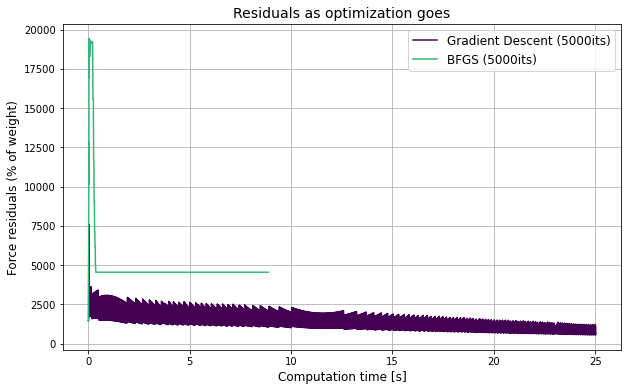

In [20]:
cmap   = plt.get_cmap('viridis')
colors = cmap(torch.linspace(0.0, 1.0, 4))

gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
fig = plt.figure(figsize=(10, 6))

axTmp = plt.subplot(gs[0, 0])
axTmp.plot(times_GD[:idx_stop_GD+1], 100.0 * residuals_GD[:idx_stop_GD+1] / weight, c=colors[0], 
           label="Gradient Descent ({:}its)".format(idx_stop_GD))
axTmp.plot(times_BFGS[:idx_stop_BFGS+1], 100.0*residuals_BFGS[:idx_stop_BFGS+1] / weight, c=colors[2], 
           label="BFGS ({:}its)".format(idx_stop_BFGS))
y_lim = axTmp.get_ylim()
axTmp.set_title("Residuals as optimization goes", fontsize=14)
axTmp.set_xlabel("Computation time [s]", fontsize=12)
axTmp.set_ylabel("Force residuals (% of weight)", fontsize=12)
axTmp.set_ylim(y_lim)
plt.legend(fontsize=12)
plt.grid()
plt.show()

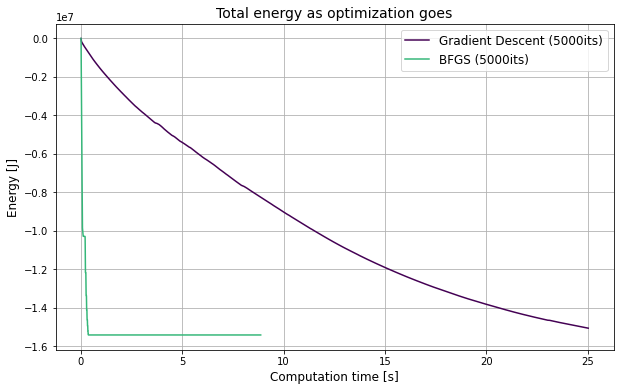

In [21]:
gs = gridspec.GridSpec(nrows=1, ncols=1, width_ratios=[1], height_ratios=[1])
fig = plt.figure(figsize=(10, 6))

axTmp = plt.subplot(gs[0, 0])
axTmp.plot(times_GD[:idx_stop_GD+1], energy_GD[:idx_stop_GD+1], c=colors[0], 
           label="Gradient Descent ({:}its)".format(idx_stop_GD))
axTmp.plot(times_BFGS[:idx_stop_BFGS+1], energy_BFGS[:idx_stop_BFGS+1], c=colors[2], 
           label="BFGS ({:}its)".format(idx_stop_BFGS))
y_lim = axTmp.get_ylim()
axTmp.set_title("Total energy as optimization goes", fontsize=14)
axTmp.set_xlabel("Computation time [s]", fontsize=12)
axTmp.set_ylabel("Energy [J]", fontsize=12)
axTmp.set_ylim(y_lim)
plt.legend(fontsize=12)
plt.grid()
plt.show()